# Testing data augmentation for CIFAR-10

In [1]:
from ay_torch import *
%matplotlib widget

In [2]:
def GetDataTransforms(mode):
  if mode=='train':
    # return torchvision.transforms.Compose([
    #     torchvision.transforms.Resize(256),
    #     torchvision.transforms.RandomAffine(degrees=(-10, 10), scale=(1.0, 1.1)),
    #     #torchvision.transforms.RandomRotation(degrees=10),
    #     torchvision.transforms.RandomHorizontalFlip(),
    #     torchvision.transforms.RandomResizedCrop(224),
    #     torchvision.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0),
    #     torchvision.transforms.ToTensor(),
    #     #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    #   ])
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(224),
        torchvision.transforms.Resize(460),
        torchvision.transforms.Pad(20, padding_mode='constant'),  #'reflect'
        # torchvision.transforms.RandomRotation(degrees=10),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(460),
        # Warp(magnitude=max_warp=0.2, p=p_affine=0.75, **tkw)
        # Zoom(min_zoom=min_zoom=1., max_zoom=max_zoom=1.1, p=p_affine=0.75, **tkw)
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.RandomAffine(degrees=(-10,10), scale=(0.75,1.1)),
        torchvision.transforms.RandomResizedCrop(224, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],type(dset_train[0][1],),dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 6 <class 'int'> frog
dset_train[0][0] value range: tensor(0.) tensor(0.7608)
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 3 cat


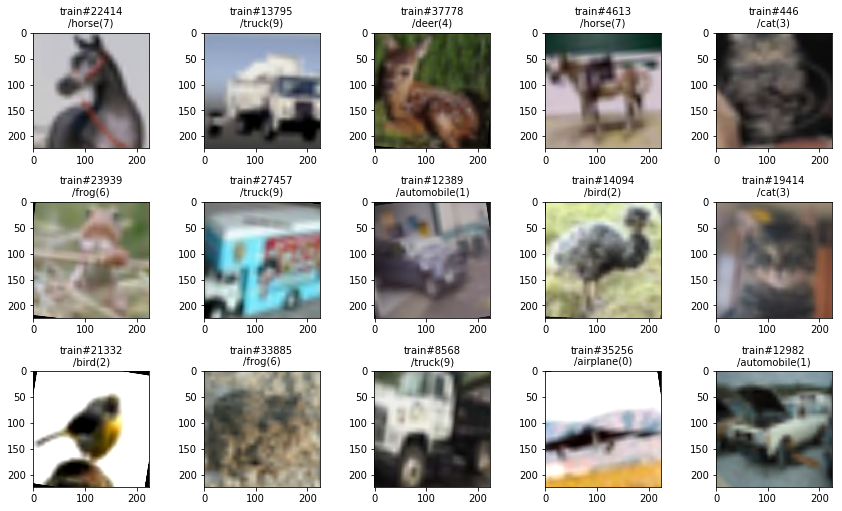

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

### TEST: Using fastai's data augmentation

The objective of this test is to know if the data augmentation of fastai contributes the learning CIFAR-10 task.

Conclusion: Yes, fastai's data augmentation increases the accuracy.

- With my data augmentation: 89.x % --> After updating, reached 92.7 % @14, but compt time/epoch is increase (169s)
- With fastai's data augmentation: 92.5 % (using pretrained parameters), 93.2 % @29 (no pretrained)

In [40]:
import fastai.vision.all
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label,
                                    item_tfms=fastai.vision.all.Resize(460),
                                    batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label )
dls= dblock.dataloaders(path, bs=64)
dl_train,dl_test= dls.train, dls.valid
dset_train,dset_test= dls.train_ds, dls.valid_ds
dset_train.classes,dset_test.classes= dl_train.vocab,dl_test.vocab

## ResNet-18 with pretrained network parameters

In [4]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

#Load pretrained model parameters.
url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger(negative_metric=False, storage='file')
disp= TDisp()

In [6]:
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 224, 224)
Layer (type (var_name))                       Input Shape               Output Shape              Param #
TResNet                                       --                        --                        --
├─Sequential (0)                              [1, 3, 224, 224]          [1, 32, 224, 224]         --
│    └─Conv2d (0)                             [1, 3, 224, 224]          [1, 32, 224, 224]         864
│    └─BatchNorm2d (1)                        [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    └─ReLU (2)                               [1, 32, 224, 224]         [1, 32, 224, 224]         --
├─Sequential (1)                              [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─Conv2d (0)                             [1, 32, 224, 224]         [1, 32, 112, 112]         9,216
│    └─BatchNorm2d (1)                        [1, 32, 112, 112]         [1, 32, 112, 112]         64
│    └─ReLU (2)                               [1, 32, 

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


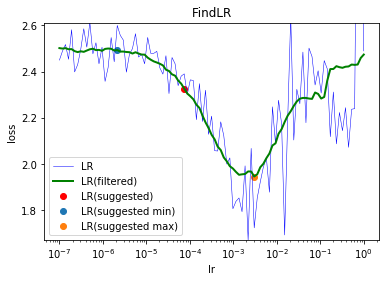

lr= 7.413102413009172e-05, lr_min=2.137962089502232e-06, lr_max=0.0030199517204020166


In [7]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	1.56730680	1.35421391	0.44092000	0.53770000	 138.172086
1	0.91773241	0.90084110	0.67484000	0.68270000	 139.660781
2	0.69788725	0.61285596	0.75800000	0.79010000	 139.445298
3	0.53212948	0.62407807	0.81550000	0.79000000	 138.814919
4	0.43746104	0.45635101	0.84714000	0.84870000	 139.972017
5	0.34959335	0.38731717	0.87912000	0.86970000	 139.459362
6	0.26713487	0.33129508	0.90576000	0.89230000	 139.881441
7	0.19722043	0.28808814	0.93172000	0.90650000	 139.796092
8	0.14685889	0.26865623	0.94886000	0.91420000	 139.611756
9	0.12061612	0.26978751	0.95894000	0.91280000	 139.119229
total epochs: 10
total time: 22.09min
best loss(train): 0.12061611613750457@9
best loss(test): 0.26865622758865354@8
best metric(train): 0.95894@9
best metric(test): 0.9142@8
last loss(train): 0.12061611613750457@10
last loss(test): 0.269787514925003@10
last metric(train): 0.95894@10
last metric(test): 0.9128@10


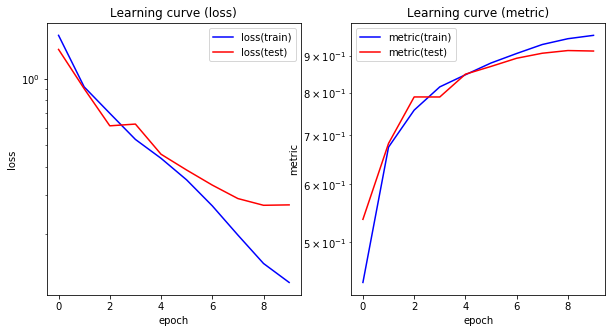

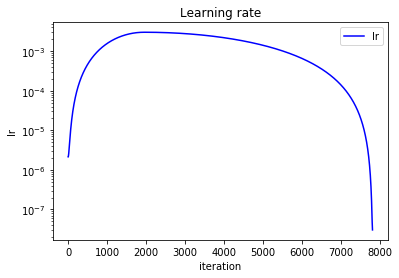

In [8]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
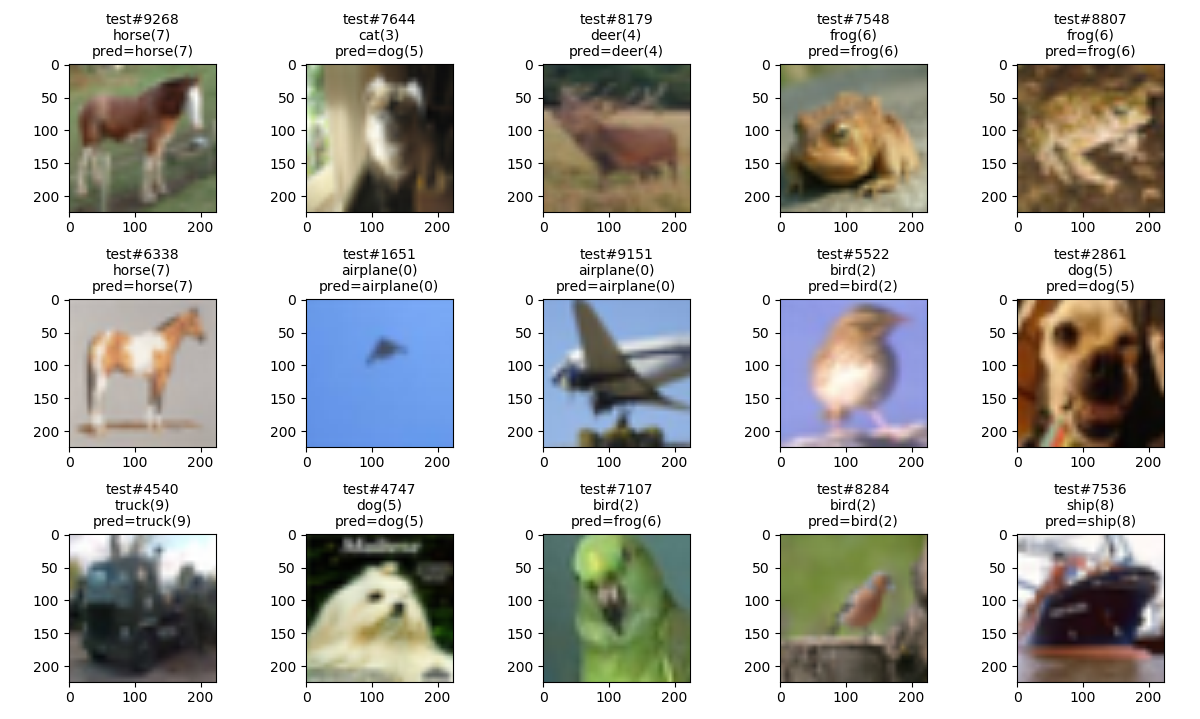

In [50]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## ResNet-18 without pretrained network parameters

In [19]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger(negative_metric=False, storage='file')
disp= TDisp()

In [ ]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

FindLR progress: 0.0%


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


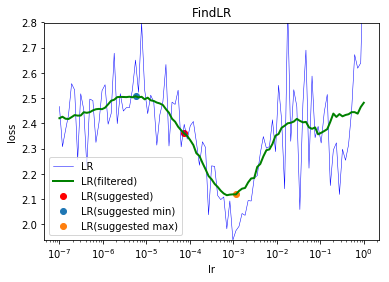

lr= 7.413102413009172e-05, lr_min=5.62341325190349e-06, lr_max=0.001148153621496882


In [21]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	0.11678427	0.28719760	0.90691489	102.346642
21	0.21925186	0.40454508	0.87283910	103.073038
22	0.25967861	0.36876889	0.88164894	103.301678
23	0.22702160	0.38691143	0.87483378	103.237663
24	0.19352214	0.31272323	0.89752327	103.070234
25	0.15430178	0.27878397	0.90774601	103.147643
26	0.11371717	0.25413959	0.91971410	103.264879
27	0.08048933	0.22971035	0.92910572	103.339758
28	0.06094797	0.22166467	0.93101729	102.730049
29	0.05141830	0.21617413	0.93209774	103.183279


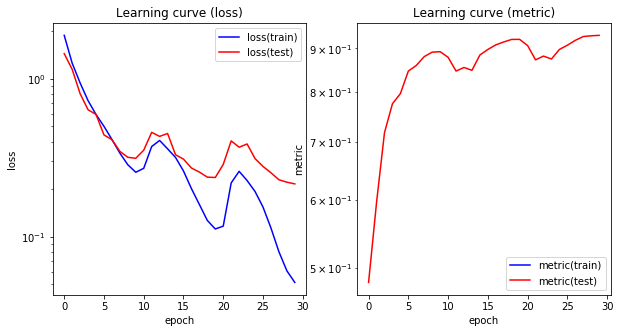

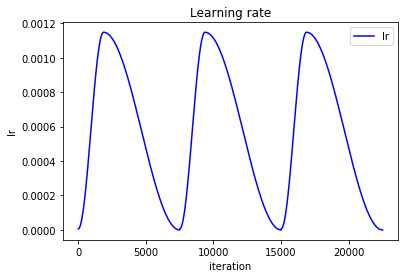

In [24]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## Tiny ResNet made with ResBlock

In [16]:
class TResNetTiny(torch.nn.Module):
  def __init__(self, n_classes):
    super(TResNetTiny,self).__init__()
    # n_layers= [3,16,32,64,128,256]
    # strides= [1,2,2,2,2,2]  #For 224x224 images
    n_layers= [3,16,32,64,128]
    strides= [1,2,2,2,2]  #For 224x224 images
    self.net= torch.nn.Sequential(
          *[TResBlock(1, c_in, c_out, kernel_size=3, stride=s) for c_in,c_out,s in zip(n_layers[:-1],n_layers[1:],strides)],
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(n_layers[-1], n_classes)
          )
  def forward(self, x):
    return self.net(x)

In [17]:
#Setup a neural network.
net= TResNetTiny(n_classes=len(dset_train.classes))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger(negative_metric=False, storage='file')
disp= TDisp()

In [18]:
# input_size= (1,)+dset_train[0][0].shape
input_size= (1,3,224,224)
Summary(net, input_size)

input_size=(1, 3, 224, 224)
Layer (type (var_name))                       Input Shape               Output Shape              Param #
TResNetTiny                                   --                        --                        --
├─Sequential (net)                            [1, 3, 224, 224]          [1, 10]                   --
│    └─TResBlock (0)                          [1, 3, 224, 224]          [1, 16, 224, 224]         --
│    │    └─Sequential (convpath)             [1, 3, 224, 224]          [1, 16, 224, 224]         --
│    │    │    └─Sequential (0)               [1, 3, 224, 224]          [1, 16, 224, 224]         --
│    │    │    │    └─Conv2d (0)              [1, 3, 224, 224]          [1, 16, 224, 224]         432
│    │    │    │    └─BatchNorm2d (1)         [1, 16, 224, 224]         [1, 16, 224, 224]         32
│    │    │    │    └─ReLU (2)                [1, 16, 224, 224]         [1, 16, 224, 224]         --
│    │    │    └─Sequential (1)               [1, 16, 224

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


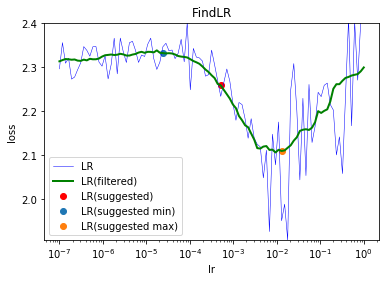

lr= 0.000512861383991365, lr_min=2.3988329190194914e-05, lr_max=0.012882495516931335


In [19]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	2.01059247	1.80965220	0.25502000	0.32150000	 138.781464
1	1.66154701	1.67501373	0.37768000	0.40210000	 139.678947
2	1.46633227	1.43425629	0.46944000	0.47100000	 144.782006
3	1.30986452	1.26466998	0.53036000	0.54820000	 144.744691
4	1.19327462	1.29379149	0.57560000	0.54860000	 144.682553
5	1.11054107	1.12359013	0.60840000	0.59480000	 144.116999
6	1.03644213	1.03568918	0.63368000	0.63370000	 138.609291
7	0.97390868	0.93492974	0.65648000	0.67150000	 139.002831
8	0.92677627	0.93718671	0.67686000	0.66790000	 138.481340
9	0.90233451	0.93298329	0.68564000	0.66990000	 138.648882
total epochs: 10
total time: 22.59min
best loss(train): 0.9023345125198364@9
best loss(test): 0.9329832931518555@9
best metric(train): 0.68564@9
best metric(test): 0.6715@7
last loss(train): 0.9023345125198364@10
last loss(test): 0.9329832931518555@10
last metric(train): 0.68564@10
last metric(test): 0.6699@10


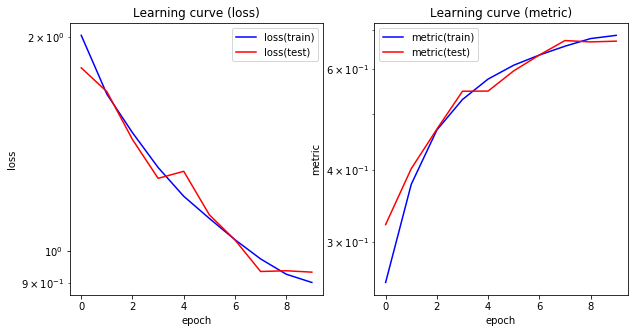

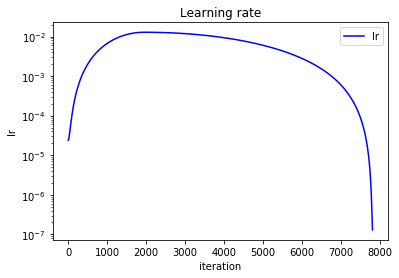

In [20]:
# lr_min,lr_max=1e-6,2e-3
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Show()

total epochs: 10
total time: 22.59min
best loss(train): 0.9023345125198364@9
best loss(test): 0.9329832931518555@9
best metric(train): 0.68564@9
best metric(test): 0.6715@7
last loss(train): 0.9023345125198364@10
last loss(test): 0.9329832931518555@10
last metric(train): 0.68564@10
last metric(test): 0.6699@10


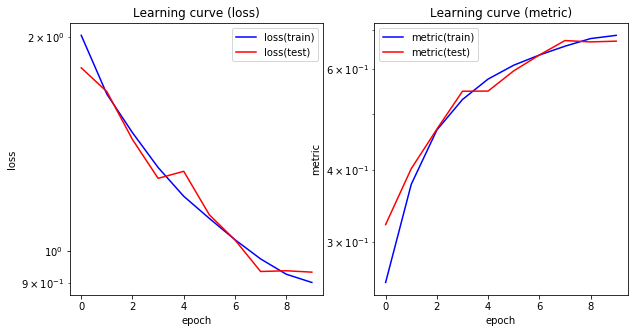

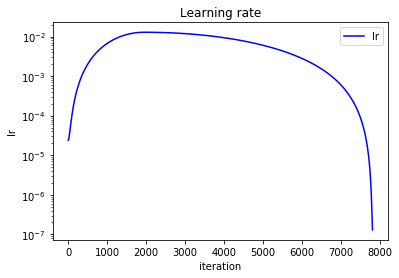

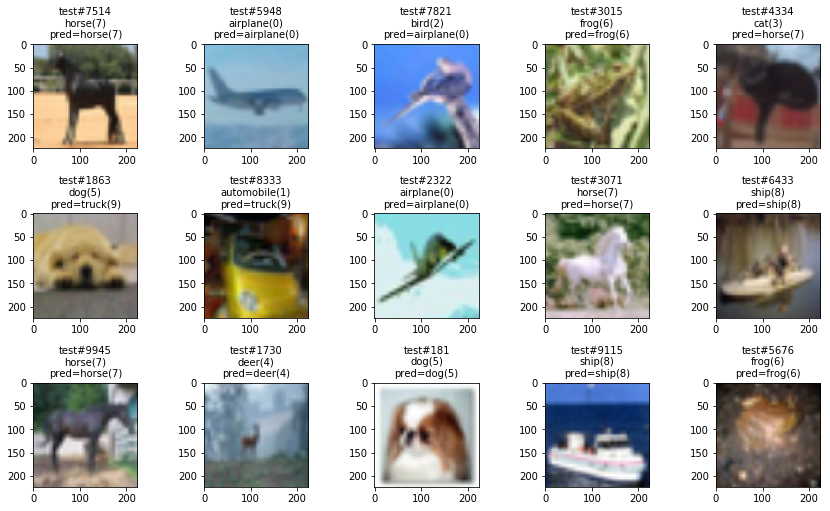

In [21]:
logger.Show()
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

In [ ]:
def f_viz(x, y, pred, idxes, is_train, **kwargs):
  imgs,labels,pred= x,y,decode(pred).cpu()
  labels= [f'{["test","train"][is_train]}#{i}\n{dset_test.classes[l]}({l})\npred={d.classes[lp]}({lp})' for i,l,lp in zip(idxes,labels,pred)]
  PlotImgGrid(imgs, labels, **kwargs)

viz= TVisualizer(net, dset_train=dset_train, dset_test=dset_test, logger=logger,
                 tfm_batch=tfm_batch, f_loss=f_loss, f_metric=f_metric, f_viz=f_viz, device=device)
viz.Show()

In [18]:
logger.LoadStates(logger, key='metric_test', net=net, opt=opt, f_loss=f_loss, device=device)

In [13]:
model_file_name= 'model_learned/resnet_cifar10_2.pt'
# logger.SaveStateDict(logger, model_file_name, 'last', device=device)
LoadStateDict(model_file_name, net=net, opt=opt, f_loss=f_loss, device=device)